In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
data = pd.read_csv('car-data/car_price_prediction.csv')

data.head(10)

'''
Data Cleaning:
Levy - Many values use '-' which should be replaced with the mean or median value of the numerical values of the column
Mileage - Remove km and make it numerical 
Engine Volume - Is not numeric and contains strings 'Turbo'
Doors has following values and must be changed to 2, 4, or 6 (ordinal scale)

04-May    18332
02-Mar      777
>5          128
'''

"\nData Cleaning:\nLevy - Many values use '-' which should be replaced with the mean or median value of the numerical values of the column\nMileage - Remove km and make it numerical \nEngine Volume - Is not numeric and contains strings 'Turbo'\nDoors has following values and must be changed to 2, 4, or 6 (ordinal scale)\n\n04-May    18332\n02-Mar      777\n>5          128\n"

In [3]:
def preprocess(data: pd.DataFrame):
   # Levy has many missing values
   data['Levy'] = pd.to_numeric(data['Levy'], errors='coerce')
   levy_mean_val = data['Levy'].mean()
   data['Levy'].fillna(levy_mean_val, inplace=True)
   
   # Mileage
   data['Mileage'] = pd.to_numeric((data['Mileage']).astype(str).str.replace(' km', '', regex=True), errors='coerce')

   # Doors
   data['Doors'] = data['Doors'].astype(str).str.extract(r'(\d+)', expand=False).astype(int).map({4: 4, 2: 2, 5: 6})  # Map values

   # Engine Volume
   data['Engine volume'] = pd.to_numeric(data['Engine volume'].astype(str).str.replace(' Trubo', '', regex=True), errors='coerce')

   # Find age of car rather than having year of production
   data['Age'] = 2025 - data['Prod. year']
   data = data.drop(columns=['Prod. year'])

   # Adjust column names and remove spaces
   data.columns = data.columns.str.strip().str.replace(' ', '_')

   # Drop ID column 
   data = data.drop(columns=['ID'])
   data = data.dropna()

   return data

def split_data(data: pd.DataFrame):
   # Split data 
   train, test = train_test_split(data, test_size=0.2, random_state=123)
   y_train = train.pop('Price') # Keep only price column in train 
   X_train = train
   y_test = test.pop('Price')
   X_test = test

   return X_train, y_train, X_test, y_test

def OHE_data(data: pd.DataFrame):
   # OHE Categorical Data
   # Removed Model (This adds over 1500 more columns)
   # data = data.drop(columns=['Model'])
   return pd.get_dummies(data, columns=['Manufacturer', 'Category', 'Model', 'Leather_interior', 'Fuel_type', 'Gear_box_type', 'Drive_wheels', 'Wheel', 'Color'])
   

processed_data = preprocess(data) # Use full dataset for data analysis
OHE_processed_data = OHE_data(processed_data)
X_train, y_train, X_test, y_test = split_data(OHE_processed_data) # Use train/test split data for modeling


In [4]:
processed_data.head()

,Price,Levy,Manufacturer,Model,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Age
0,13328,1399.000000,LEXUS,RX 450,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left wheel,Silver,12,15
1,16621,1018.000000,CHEVROLET,Equinox,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,8,14
2,8467,906.838128,HONDA,FIT,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2,19
3,3607,862.000000,FORD,Escape,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,0,14
4,11726,446.000000,HONDA,FIT,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4,11


In [5]:
X_train.head()

,Levy,Engine_volume,Mileage,Cylinders,Doors,Airbags,Age,Manufacturer_ACURA,Manufacturer_ALFA ROMEO,Manufacturer_ASTON MARTIN,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
5184,586.0,1.8,130000,4.0,4,4,13,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6109,697.0,1.8,70000,4.0,4,4,10,False,False,False,...,False,False,False,False,False,False,True,False,False,False
19098,687.0,1.6,72000,4.0,4,4,15,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4388,585.0,1.8,207606,4.0,4,12,12,False,False,False,...,False,True,False,False,False,False,False,False,False,False
14960,843.0,1.5,135000,4.0,4,12,17,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [6]:
''' Data is cleaned and prepped'''

' Data is cleaned and prepped'

**EXAMINING NUMERICAL FEATURES**

In [7]:
'''
Numerical Predictor Columns:
Levy
Age
Engine volume
Mileage
Cylinders
Doors
Airbags
'''

'\nNumerical Predictor Columns:\nLevy\nAge\nEngine volume\nMileage\nCylinders\nDoors\nAirbags\n'

                  Price      Levy  Engine_volume   Mileage  Cylinders  \
Price          1.000000 -0.052760       0.028931 -0.207104  -0.076461   
Levy          -0.052760  1.000000       0.501579  0.040286   0.499632   
Engine_volume  0.028931  0.501579       1.000000  0.153843   0.690841   
Mileage       -0.207104  0.040286       0.153843  1.000000   0.171759   
Cylinders     -0.076461  0.499632       0.690841  0.171759   1.000000   
Doors          0.037639 -0.069234      -0.004969  0.004411  -0.052178   
Airbags       -0.107843  0.104474       0.265027 -0.011818   0.208241   
Age           -0.289000  0.180989       0.015227  0.341118   0.174210   

                  Doors   Airbags       Age  
Price          0.037639 -0.107843 -0.289000  
Levy          -0.069234  0.104474  0.180989  
Engine_volume -0.004969  0.265027  0.015227  
Mileage        0.004411 -0.011818  0.341118  
Cylinders     -0.052178  0.208241  0.174210  
Doors          1.000000  0.032958 -0.134921  
Airbags        0.032

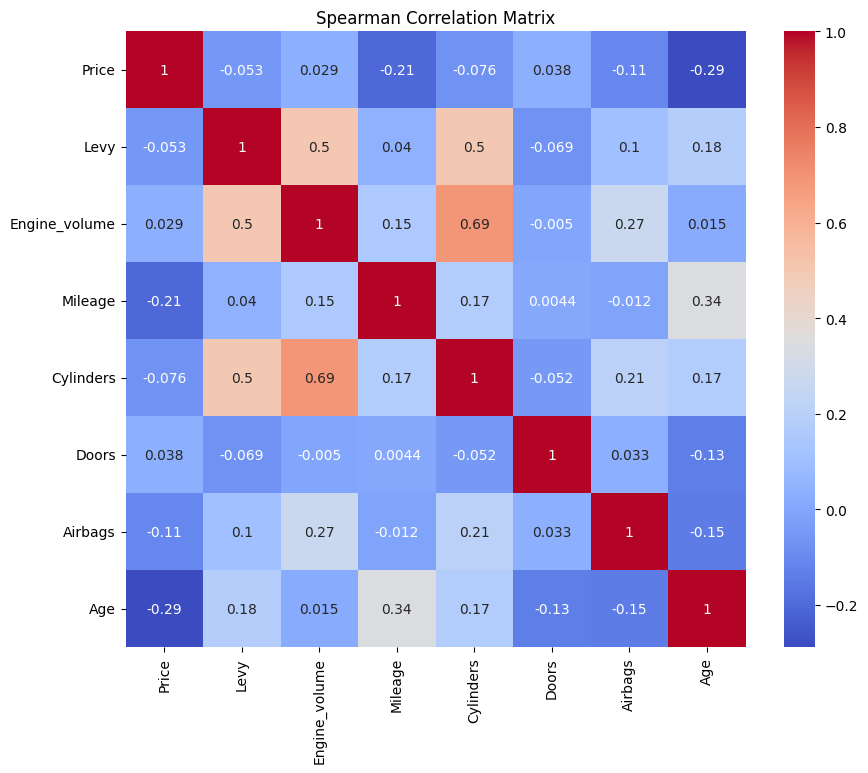

                  Price      Levy  Engine_volume   Mileage  Cylinders  \
Price          1.000000  0.004674       0.002824 -0.001687  -0.000762   
Levy           0.004674  1.000000       0.553816  0.001811   0.490957   
Engine_volume  0.002824  0.553816       1.000000 -0.007432   0.798073   
Mileage       -0.001687  0.001811      -0.007432  1.000000  -0.000519   
Cylinders     -0.000762  0.490957       0.798073 -0.000519   1.000000   
Doors         -0.035394 -0.037713      -0.022675  0.004140  -0.046275   
Airbags       -0.019714  0.085748       0.232824 -0.006828   0.167710   
Age           -0.008188  0.097373       0.024350  0.067885   0.113896   

                  Doors   Airbags       Age  
Price         -0.035394 -0.019714 -0.008188  
Levy          -0.037713  0.085748  0.097373  
Engine_volume -0.022675  0.232824  0.024350  
Mileage        0.004140 -0.006828  0.067885  
Cylinders     -0.046275  0.167710  0.113896  
Doors          1.000000  0.031231 -0.184563  
Airbags        0.031

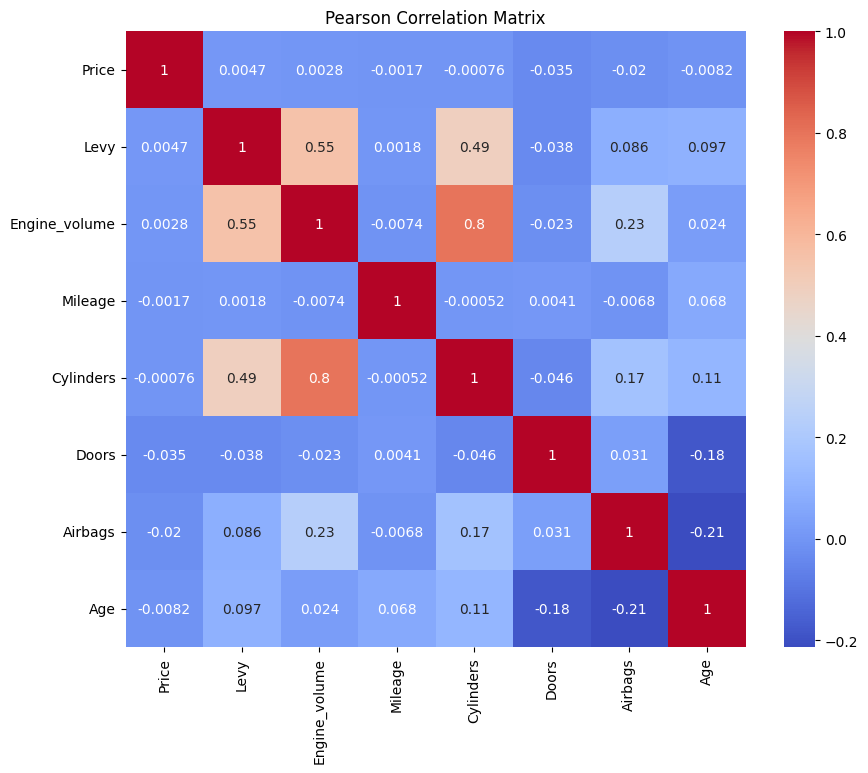

In [8]:
numerical_columns = processed_data.select_dtypes(include=['float64', 'int64'])
numerical_columns.head()

# Compute the SPEARMAN correlation matrix
corr_matrix_spearman = numerical_columns.corr(method='spearman')
print(corr_matrix_spearman)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_spearman, annot=True, cmap='coolwarm')
plt.title("Spearman Correlation Matrix")
plt.show()

# Compute the PEARSON correlation matrix
corr_matrix_pearson = numerical_columns.corr(method='pearson')
print(corr_matrix_pearson)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_pearson, annot=True, cmap='coolwarm')
plt.title("Pearson Correlation Matrix")
plt.show()

Spearman Correlation Matrix: (Focus on monotonic relationships - can be nonlinear)
- Price has a weak negative correlation with mileage (-0.20) and age (-0.29)
- Price has ittle to no correlation with any of the other predictors
- Cylinders and engine volume have a moderately strong, positive correlation of 0.69
- Engine volume and levy have a moderatem positive correlation of 0.5 
- Cylinder and levy have a moderate positive correlation of 0.49

Pearson Correlation Matrix: (Measures linear relationships)
- Cylinders and engine volume have a strong, positive correlation of 0.8
- Levy and cylinders and levy and engine volume have similar moderate, positive correations of 0.46 and 0.55 respectivly  


In [9]:
# OLS for predicting price

formula = 'Price ~ Levy + Age + Engine_volume + Mileage + Cylinders + Doors + Airbags + C(Manufacturer) + C(Model) + C(Category) + C(Leather_interior) + C(Fuel_type) + C(Gear_box_type) + C(Drive_wheels) + C(Wheel) + C(Color)'

OLS_model = smf.ols(formula=formula, data=processed_data).fit()
print(OLS_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.7128
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               1.00
Time:                        19:29:13   Log-Likelihood:            -2.3535e+05
No. Observations:               17306   AIC:                         4.734e+05
Df Residuals:                   15981   BIC:                         4.836e+05
Df Model:                        1324                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [10]:
# ANOVA
anova_table = sm.stats.anova_lm(OLS_model, typ=2)
print(anova_table)

                           sum_sq       df          F    PR(>F)
C(Manufacturer)      8.981582e+11     63.0   0.346433  1.000000
C(Model)             3.009282e+13   1271.0   0.575340  1.000000
C(Category)          2.876102e+11     10.0   0.698894  0.726468
C(Leather_interior)  5.924830e+09      1.0   0.143974  0.704367
C(Fuel_type)         3.536121e+11      6.0   1.432131  0.197885
C(Gear_box_type)     1.800834e+11      3.0   1.458678  0.223661
C(Drive_wheels)      5.631063e+10      2.0   0.684175  0.504521
C(Wheel)             2.241186e+09      1.0   0.054461  0.815478
C(Color)             5.426443e+11     15.0   0.879085  0.587919
Levy                 5.859466e+10      1.0   1.423852  0.232788
Age                  3.883144e+10      1.0   0.943605  0.331367
Engine_volume        1.191536e+10      1.0   0.289544  0.590521
Mileage              6.234634e+08      1.0   0.015150  0.902040
Cylinders            2.788524e+08      1.0   0.006776  0.934395
Doors                6.842507e+11      1

- Having this many predictors is clearly causing issues in predictive power of model.
- Must conduct feature selection to check for multi-colienarity and use Variance Inflation Factor (VIF) to see which variables are redundant
- VIF > 5 means there is likely colinearly in in the feature with other features in model

In [11]:
''' It seems the numerical features all have VIF values under 5. Engine volume and cylinders have the highest VIF values, however, they are not so high that it warrants feature removal'''

formula_numerical = 'Price ~ Levy + Age + Engine_volume + Mileage + Cylinders + Doors + Airbags'
y, X = dmatrices(formula_numerical, data=processed_data, return_type='dataframe')
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))

         Feature         VIF
0      Intercept  142.222926
3  Engine_volume    3.168038
5      Cylinders    2.844389
1           Levy    1.469046
2            Age    1.126136
7        Airbags    1.115534
6          Doors    1.036400
4        Mileage    1.005112


In [12]:
processed_data.head()

,Price,Levy,Manufacturer,Model,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Age
0,13328,1399.000000,LEXUS,RX 450,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left wheel,Silver,12,15
1,16621,1018.000000,CHEVROLET,Equinox,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,8,14
2,8467,906.838128,HONDA,FIT,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2,19
3,3607,862.000000,FORD,Escape,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,0,14
4,11726,446.000000,HONDA,FIT,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4,11


**FULL CORRELATION MATRIX**

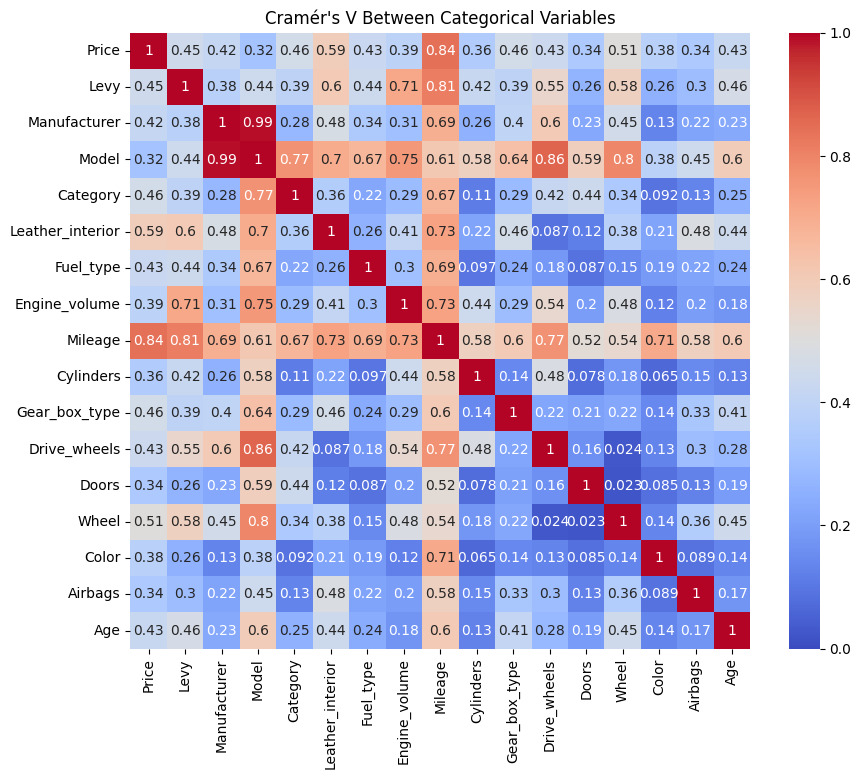

In [13]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] == 1 or confusion_matrix.shape[1] == 1:
        return np.nan  # not enough variability
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

categorical_cols = [
    'Manufacturer', 'Model', 'Category', 'Leather_interior', 'Fuel_type',
    'Gear_box_type', 'Drive_wheels', 'Wheel', 'Color'
]

all_columns = processed_data.columns

cramers_results = pd.DataFrame(index=all_columns, columns=all_columns)

for feature_1 in all_columns:
    for feature_2 in all_columns:
        if feature_1 == feature_2:
            cramers_results.loc[feature_1, feature_2] = 1.0
        else:
            try:
                subset = processed_data[[feature_1, feature_2]].dropna()
                value = cramers_v(subset[feature_1], subset[feature_2])
                cramers_results.loc[feature_1, feature_2] = value
            except Exception as e:
                print(f"Error between {feature_1} and {feature_2}: {e}")
                cramers_results.loc[feature_1, feature_2] = None

cramers_results = cramers_results.astype(float)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_results, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Cramér's V Between Categorical Variables")
plt.show()

- Model and manufacturer have almost perfect correlation of 0.99
- Model had a very high correlation with many of the other predictors such as wheel, Drive wheels, gear box type, leather interior, category, and manufacturer
- Should remove Model feature since there is too much correlation between this and other variables
- Mileage also shows very high correlation with all other variables

**ANALYSIS USING 1000+ FEATURES (INCLUDING Model)**

                                 PC1       PC2
Engine_volume               0.335902  0.087010
Cylinders                   0.305927  0.139622
Drive_wheels_4x4            0.249749  0.125941
Leather_interior_Yes        0.229084 -0.249889
Category_Jeep               0.202955 -0.028171
Levy                        0.185992  0.137102
Wheel_Left wheel            0.170219 -0.169350
Manufacturer_MERCEDES-BENZ  0.161313  0.111036
Manufacturer_LEXUS          0.150222  0.010180
Model_E 350                 0.118236  0.028159
Model_GX 460                0.115567  0.027350
Color_Black                 0.111352  0.017380
Manufacturer_BMW            0.103542  0.106084
Drive_wheels_Rear           0.102169  0.194348
Airbags                     0.090729 -0.032275
Model_X5                    0.090000  0.028884
Model_GX 470                0.089056  0.025325
Fuel_type_Diesel            0.085063 -0.108183
Model_ML 350                0.076578  0.013576
Gear_box_type_Automatic     0.075216 -0.261575


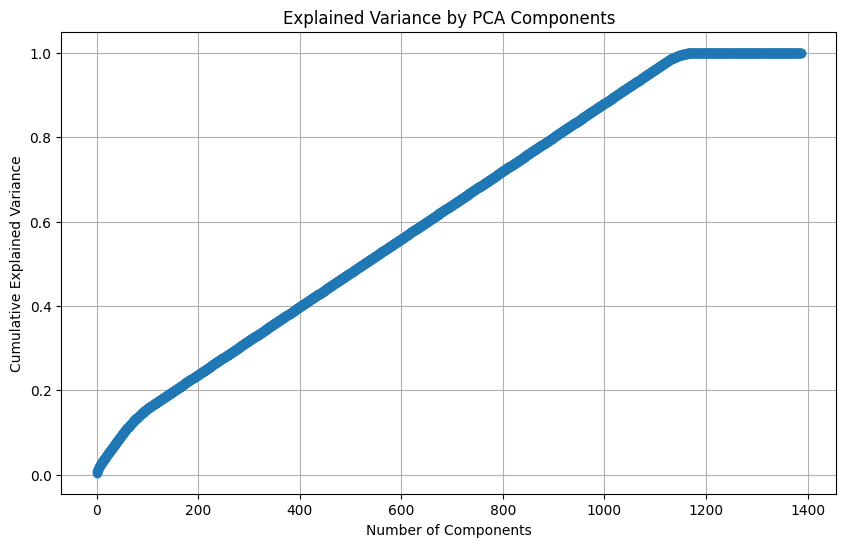

In [14]:
# Standardize features using training sample
X = X_train

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_


# Create a loadings DataFrame
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(X.columns))],
    index=X.columns
)

# View top contributors to PC1 and PC2
print(loadings[['PC1', 'PC2']].sort_values(by='PC1', ascending=False).head(20))


plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [15]:
# OLS regression with PCA components (PCR)

# Find the top PC's that explain 95% of the variance
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)
X_pca_95 = pca.fit_transform(X_scaled)

print(f"Number of components kept: {X_pca_95.shape[1]}")  # should be more than 1

# Run OLS on all of them
X_pca_95_const = sm.add_constant(X_pca_95)
ols_model = sm.OLS(y_train, X_pca_95_const).fit()
print(ols_model.summary())

Number of components kept: 1088
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.7904
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               1.00
Time:                        19:29:50   Log-Likelihood:            -1.8974e+05
No. Observations:               13844   AIC:                         3.817e+05
Df Residuals:                   12755   BIC:                         3.899e+05
Df Model:                        1088                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.781e+0

In [16]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score

# 1. Scale the full feature set
X_scaled = scaler.fit_transform(X_train)

# 2. PCA: keep components that explain 95% of the variance
pca = PCA(n_components=0.95)
X_pca_95 = pca.fit_transform(X_scaled)

print(f"✅ Number of components kept: {X_pca_95.shape[1]}")

# 3. Set up model
model = LinearRegression()

# 4. Define custom scorers
rmse_scorer = make_scorer(lambda y_true, y_pred: root_mean_squared_error(y_true, y_pred))  # RMSE
r2_scorer = make_scorer(r2_score)

# 5. Set up Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=100)

# 6. Run Cross-Validation
rmse_scores = cross_val_score(model, X_pca_95, y_train, cv=kf, scoring=rmse_scorer)
r2_scores = cross_val_score(model, X_pca_95, y_train, cv=kf, scoring=r2_scorer)

# 7. Results for CV
print(f"🔹 Average CV RMSE: {np.mean(rmse_scores):.2f}")
print(f"🔹 Average CV R²: {np.mean(r2_scores):.4f}")

# 8. Fit final model on all training data
model.fit(X_pca_95, y_train)

# 9. Transform and evaluate on TEST set
X_test_scaled = scaler.transform(X_test)       # IMPORTANT: use same scaler
X_test_pca = pca.transform(X_test_scaled)       # IMPORTANT: use same PCA
y_pred_test = model.predict(X_test_pca)

print(f"🧪 Test Set R²: {r2_score(y_test, y_pred_test):.4f}")
print(f"🧪 Test Set RMSE: {root_mean_squared_error(y_test, y_pred_test):.2f}")


✅ Number of components kept: 1088
🔹 Average CV RMSE: 25184446286951460864.00
🔹 Average CV R²: -2966779971373125632366867382272.0000
🧪 Test Set R²: -6.4505
🧪 Test Set RMSE: 58050.54


**RIDGE REGRESSION**

In [17]:
from sklearn.linear_model import Ridge

# 1. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. PCA to keep 95% variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 3. Ridge Model
ridge = Ridge(alpha=2)

# 4. Custom Scorers
rmse_scorer = make_scorer(lambda y_true, y_pred: root_mean_squared_error(y_true, y_pred))
r2_scorer = make_scorer(r2_score)

# 5. Cross-Validation Setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 6. Cross-Validation Scores
rmse_scores = cross_val_score(ridge, X_train_pca, y_train, cv=kf, scoring=rmse_scorer)
r2_scores = cross_val_score(ridge, X_train_pca, y_train, cv=kf, scoring=r2_scorer)

# 7. Print results
print(f"🔹 Average Ridge CV RMSE: {np.mean(rmse_scores):.2f}")
print(f"🔹 Average Ridge CV R²: {np.mean(r2_scores):.4f}")

# 8. Train final model on all training data
ridge.fit(X_train_pca, y_train)

# 9. Evaluate on test set
y_pred_ridge = ridge.predict(X_test_pca)
print("🧪 Ridge Test R²:", r2_score(y_test, y_pred_ridge))
print("🧪 Ridge Test RMSE:", root_mean_squared_error(y_test, y_pred_ridge))

🔹 Average Ridge CV RMSE: 720190.47
🔹 Average Ridge CV R²: -1731.8833
🧪 Ridge Test R²: -6.448875758092076
🧪 Ridge Test RMSE: 58044.04401394215


**LASSO REGRESSION**

In [18]:
# from sklearn.model_selection import KFold, cross_val_score
# from sklearn.linear_model import Lasso

# # 1. (Assume X_train_pca, X_test_pca, y_train, y_test are already defined)

# # 2. Lasso Model
# lasso = Lasso(alpha=1, max_iter=5000)

# # 3. Define scorers
# rmse_scorer = make_scorer(root_mean_squared_error)
# r2_scorer = make_scorer(r2_score)

# # 4. Setup Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # 5. Cross-Validation Scores
# rmse_scores = cross_val_score(lasso, X_train_pca, y_train, cv=kf, scoring=rmse_scorer)
# r2_scores = cross_val_score(lasso, X_train_pca, y_train, cv=kf, scoring=r2_scorer)

# # 6. Print CV results
# print(f"🔹 Average Lasso CV RMSE: {np.mean(rmse_scores):.2f}")
# print(f"🔹 Average Lasso CV R²: {np.mean(r2_scores):.4f}")

# # 7. Train final Lasso model on full training set
# lasso.fit(X_train_pca, y_train)

# # 8. Evaluate on test set
# y_pred_lasso = lasso.predict(X_test_pca)
# print("🧪 Lasso Test R²:", r2_score(y_test, y_pred_lasso))
# print("🧪 Lasso Test RMSE:", root_mean_squared_error(y_test, y_pred_lasso))


**NONLINEAR MODELS**

In [19]:
# Decision trees (Without PCA)
from sklearn.tree import DecisionTreeRegressor

# 1. Set up the Decision Tree Regressor
tree = DecisionTreeRegressor(max_depth=500, random_state=100) # May tune max depth

# 2. Define scorers
rmse_scorer = make_scorer(root_mean_squared_error)
r2_scorer = make_scorer(r2_score)

# 3. Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. Cross-validation scores
rmse_scores = cross_val_score(tree, X_train, y_train, cv=kf, scoring=rmse_scorer)
r2_scores = cross_val_score(tree, X_train, y_train, cv=kf, scoring=r2_scorer)

# 5. Print CV results
print(f"🔹 Average Decision Tree CV RMSE: {np.mean(rmse_scores):.2f}")
print(f"🔹 Average Decision Tree CV R²: {np.mean(r2_scores):.4f}")

# 6. Train final model on full training set
tree.fit(X_train, y_train)

# 7. Evaluate on test set
y_pred_tree = tree.predict(X_test)
print("🧪 Decision Tree Test R²:", r2_score(y_test, y_pred_tree))
print("🧪 Decision Tree Test RMSE:", root_mean_squared_error(y_test, y_pred_tree))


🔹 Average Decision Tree CV RMSE: 206052.59
🔹 Average Decision Tree CV R²: -200.5788
🧪 Decision Tree Test R²: 0.40145599723445957
🧪 Decision Tree Test RMSE: 16453.577428413184


In [20]:
# Decision trees (With PCA)

# 1. Set up the Decision Tree Regressor
tree = DecisionTreeRegressor(max_depth=500, random_state=100) # Tune max depth

# 2. Define scorers
rmse_scorer = make_scorer(root_mean_squared_error)
r2_scorer = make_scorer(r2_score)

# 3. Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. Cross-validation scores
rmse_scores = cross_val_score(tree, X_train_pca, y_train, cv=kf, scoring=rmse_scorer)
r2_scores = cross_val_score(tree, X_train_pca, y_train, cv=kf, scoring=r2_scorer)

# 5. Print CV results
print(f"🔹 Average Decision Tree CV RMSE: {np.mean(rmse_scores):.2f}")
print(f"🔹 Average Decision Tree CV R²: {np.mean(r2_scores):.4f}")

# 6. Train final model on full training set
tree.fit(X_train_pca, y_train)

# 7. Evaluate on test set
y_pred_tree = tree.predict(X_test_pca)
print("🧪 Decision Tree Test R²:", r2_score(y_test, y_pred_tree))
print("🧪 Decision Tree Test RMSE:", root_mean_squared_error(y_test, y_pred_tree))


🔹 Average Decision Tree CV RMSE: 208336.73
🔹 Average Decision Tree CV R²: -169.2794
🧪 Decision Tree Test R²: 0.20277065547559037
🧪 Decision Tree Test RMSE: 18989.080491312376
